In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta as td
import tkinter as tk
import tkinter.filedialog, tkinter.messagebox
import tkinter.ttk as ttk
from pulp import*
from ortoolpy import addvars, addbinvars
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from opt_gui import show_table

In [2]:
def pulp_to_int(tgtlist):
    int_list = [int(str(tgtlist[i])) for i in range (len(tgtlist))]
    return int_list 

In [3]:
# ファイル選択ダイアログの表示
root2 = tk.Tk()
root2.withdraw()

# ここの1行を変更　fTyp = [("","*")] →　fTyp = [("","*.csv")]
fTyp = [("","*.csv")]
curdir = os.getcwd()
iDir = curdir
file = tkinter.filedialog.askopenfilename(filetypes = fTyp ,initialdir = iDir)


tbl1 = pd.read_csv(file) #csvの読み込み

a = pd.to_datetime(tbl1['入港日'])
b = pd.to_datetime(tbl1['希望納品日'])
daymin = a.min()+ td(days=1) #すべてのコンテナの入港日のうち一番若い日付+1日を取得
daymax = b.max()  #すべてのコンテナの希望納品日のうち一番先の日付を取得
day = (daymax - daymin).days + 1 #日数
daylist =[daymin.date() + td(days = i) for i in range(day)] 
# 今回のサンプルはdaymin=1/27、daymax=2/15なので1/27-2/15の日付リストを作成する。
ctn = len(tbl1) #コンテナ数
tbl0 = np.zeros(ctn*day).reshape(ctn,day)
tbl2 = np.zeros(ctn*day).reshape(ctn,day)
for i in range(ctn):
    wnt = (b[i]-daymin).days
    pod = (a[i]-daymin).days
    tbl0[i,wnt]=1 # 納品希望日を1にする
    tbl2[i,pod+1:wnt]=1 # 入港日+1日～納品希望日まで1にする。
tbl0 = tbl0.astype(np.bool).copy() #希望日付を1に変更
tbl2 = tbl2.astype(np.bool).copy() #希望日付を1に変更
before_list = [lpSum(tbl0[:,i]) for i in range(day)]

tbl_2 = ~tbl2 #最小化問題のため、Trueで納品できたときは目的関数の計算で0になるようにする。~でFalseとTrueを裏返す。
tbl_2 = tbl_2.astype(np.int) #0と1に戻す。

/tmp/ipykernel_12827/28779521.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tbl0 = tbl0.astype(np.bool).copy() #希望日付を1に変更
/tmp/ipykernel_12827/28779521.py:30: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tbl2 = tbl2.astype(np.bool).copy() #希望日付を1に変更
/tmp/ipykernel_12827/28779521.py:34: DeprecationWarning: `np.int` is a deprecated alias for 

In [4]:
# 倉庫受入枠のテーブル。平日は5本/日、土日は0本/日とする。
tbl3 = np.zeros(day)
count = daymin
for i in range(day):
    if count.weekday() == 5 or count.weekday() == 6: #5が土曜、6が日曜
        tbl3[i] = 0
    else:
        tbl3[i] = 5
    count += td(days=1)

In [5]:
tbl4 = tbl_2*10000
for i in range(ctn):
    pod = (a[i]-daymin).days
    count = 0 
    for j in range(day-pod):
        tbl4[i,j+pod]=count
        count+=1

# 入港日+1日以前には納品できないので、最適解にならないよう10000点を置く。
# 入港日+1日以降の納品は物理的には可能なので、0から数字を置いていく。
# なるべく前の日付で納品されるよう、若い順に0から点数をつける。

In [6]:
tbl5 = np.array(addbinvars(day,ctn))
#コンテナ本数×日数の変数matrix方を作成(バイナリ変数)

tbl6 = addvars(day) # 納品オーバーを計算し入れるための変数（非負変数）を日数分作成

tbl_2 = tbl_2.T.tolist() #目的関数作成用に変換
tbl3 = tbl3.T.tolist()
tbl4 = tbl4.T.tolist()

In [7]:
Cwhs = 100 #受入枠を超えたときのペナルティ
Cnwnt = 10 #納品希望日以外のペナルティ(この定数とtbl4の内積がペナルティ)
Clt = 1 #リードタイムが1日増えると1点ペナルティ。LT重みは1のため不要だが、今後の修正のために残す。

m = LpProblem(sense=LpMinimize) #最小化問題の宣言
m += (Cwhs * lpSum(tbl6)
    + Cnwnt * lpDot(tbl_2,tbl5)
    + Clt * lpDot(tbl4,tbl5))
# 目的関数の式
# 1行目は納品制限本数を超過した本数当たり、納品オーバー分のペナルティ
# 2行目は納品可能日ではない日に納品した本数あたり、希望不可分のペナルティ
# 3行目は各コンテナ納品した日付でのLT合計。
# すべての合計が最小になるときのスケジュール表を出力

for i in range(day):
    m += tbl6[i] >= (lpSum(tbl5[i,:])-tbl3[i])
# 制約条件の式1
# 納品オーバーの計算式（納品本数ー最大納品数）になる。
# 納品本数オーバーは非負の変数で（納品本数ー最大納品数）以上の任意の正の値
# 目的関数上、任意の値のうち最小の値、すなわち（納品本数ー最大納品数）となる
# 2行目のーの式を入れたほうが納品本数のばらつきが収まる。

for j in range(ctn):
    m += lpSum(tbl5[:,j]) <= 1
    m += lpSum(tbl5[:,j]) >= 1

# 制約条件の式2
# 1コンテナあたりの納品日を必ず1つ決める

m.solve()
print('目的関数', value(m.objective))

目的関数 115.0


In [8]:
result = np.vectorize(value)(tbl5).astype(int).T #ソルバーの出力結果（日にち×コンテナ数で0-1が埋まっている）
after_list=[lpSum(result[:,i]) for i in range(day)]
daykey = [i for i in range(day)] 
datedic = {key: date for key, date in zip(daykey, daylist)} 
result = [datedic[sum(result[i]*daykey)] for i in range(ctn)] #intからdateに変換

tbl1['入港日'] = a.copy()
tbl1['希望納品日'] = b.copy()
tbl1['最適納品日']= result
tbl1.to_csv('devan_opt.csv',index=False,encoding='utf-8_sig')   

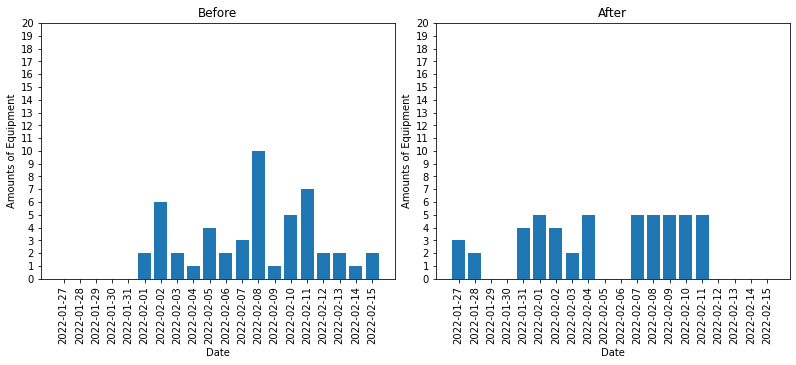

In [9]:
b_list = pulp_to_int(before_list)
a_list = pulp_to_int(after_list)
day_str = [str(daylist[i]) for i in range(len(daylist))]
x = [i for i in range(len(daylist))]
ctn_l = tbl1['コンテナ番号']
wnt_l = tbl1['希望納品日']
opt_l = tbl1['最適納品日']
show_table(ctn_l,wnt_l,opt_l,x,day_str,b_list,a_list)